# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [1]:
from fastai.vision import *
import pandas as pd
path = Path('data/saget_colbert')
path

PosixPath('data/saget_colbert')

In [2]:
path.ls()

[PosixPath('data/saget_colbert/test'),
 PosixPath('data/saget_colbert/colbert'),
 PosixPath('data/saget_colbert/.ipynb_checkpoints'),
 PosixPath('data/saget_colbert/models'),
 PosixPath('data/saget_colbert/urls_saget.csv'),
 PosixPath('data/saget_colbert/cleaned.csv'),
 PosixPath('data/saget_colbert/export.pkl'),
 PosixPath('data/saget_colbert/urls_colbert.csv'),
 PosixPath('data/saget_colbert/saget')]

## View data

In [3]:
guide = pd.read_csv(path/'cleaned.csv')
guide.head()

,name,label
0,colbert/00000124.jpg,colbert
1,colbert/00000112.jpg,colbert
2,colbert/00000109.jpg,colbert
3,colbert/00000019.jpg,colbert
4,colbert/00000028.jpg,colbert


In [4]:
# If you already cleaned your data, run this cell instead of the one before
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [5]:
data.classes

['colbert', 'saget']

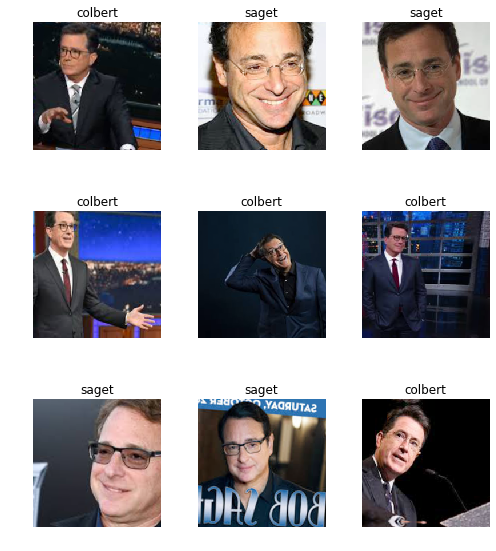

In [6]:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['colbert', 'saget'], 2, 168, 42)

## Train model

In [8]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [9]:
%time learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.200273,2.347200,0.452381,00:13
1,0.913337,3.459226,0.380952,00:03
2,0.685581,2.303655,0.333333,00:03
3,0.521612,1.602614,0.238095,00:03


CPU times: user 6.17 s, sys: 8.4 s, total: 14.6 s
Wall time: 24.6 s


In [10]:
learn.save('stage-1')

In [11]:
learn.unfreeze()

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


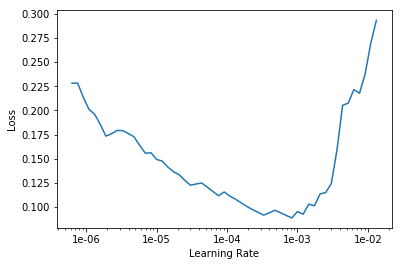

In [13]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [21]:
%time learn.fit_one_cycle(15, max_lr=slice(1e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.050089,1.284973,0.142857,00:04
1,0.033349,1.309820,0.142857,00:04
2,0.030804,1.318234,0.142857,00:04
3,0.049400,1.272743,0.142857,00:04
4,0.044068,1.229731,0.142857,00:04
5,0.036507,1.198560,0.142857,00:04
6,0.030687,1.172886,0.119048,00:04
7,0.027085,1.171924,0.119048,00:04
8,0.023905,1.185961,0.119048,00:04
9,0.026760,1.169182,0.119048,00:04


CPU times: user 33.6 s, sys: 13.4 s, total: 47 s
Wall time: 1min 4s


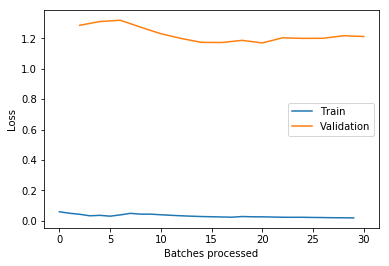

In [22]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

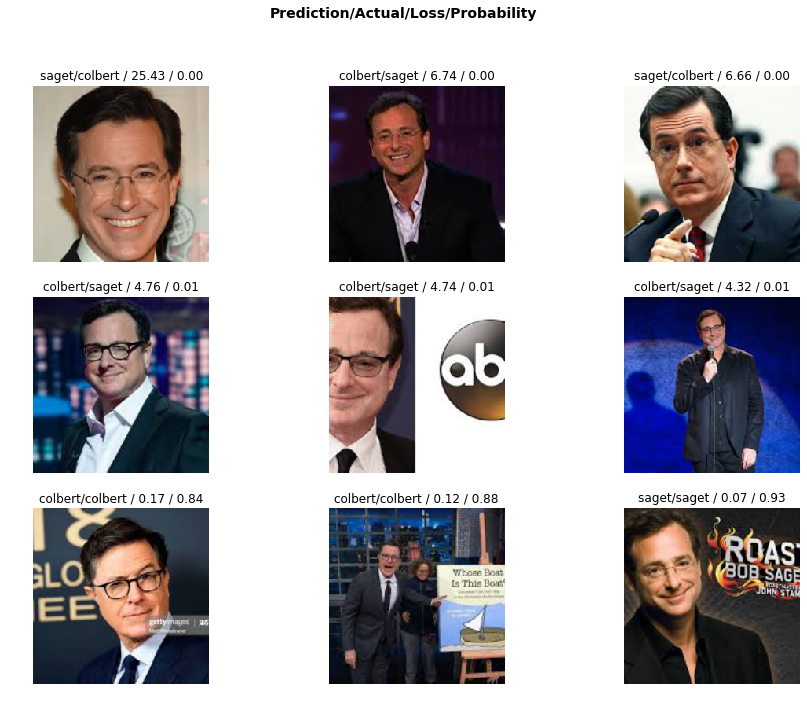

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference (*inference == predicting in production*), except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
defaults.device = torch.device('cpu')  # Just don't run this code if I want to do this on GPU

In [ ]:
img = open_image(path/'test'/'colbert_best.png')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

### Learning rate (LR) too low
A rule of thumb is that your training loss (train_loss) should **never** be bigger than your validation loss (valid_loss).

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs
This leads to **underfitting**

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

### Too many epochs
This leads to **overfitting**. One clue that you're overfitting is your error rates gets better with each epoch, but then starts getting worse again. Note that the learning rate is quite small here too.

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

In [ ]:
learn.recorder.plot_losses()